
# Computer vision
## Session 5c
### Face Recognition
- using custom datasets



In [1]:
# Import some libraries
import os

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

import cv2

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

%matplotlib inline

# %matplotlib notebook

In [2]:
# Some basic parameters
inpDir = '../input'
outDir = '../output'
dataDir = 'face_recog'

# Using LBP which is fast, there is also a more accurate but slow Haar classifier
casDir = '../resources/lbpcascades/'
casFile = 'lbpcascade_frontalface_improved.xml'


trainDir = 'train'
testDir = 'test'

RANDOM_STATE = 24

np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results

# parameters for Matplotlib
params = {'legend.fontsize': 'medium',
          'figure.figsize': (9, 6),
          'axes.labelsize': 'medium',
          'axes.titlesize':'medium',
          'xtick.labelsize':'medium',
          'ytick.labelsize':'medium'
         }

plt.rcParams.update(params)

CMAP = 'jet'

LINE_THICK = 1

# Arbit color to mark rectangles on the images
MARK_COLOR = (255, 255, 255 )

## OpenCV Face Recognizers

OpenCV has three built in face recognizers and thanks to OpenCV's clean coding, you can use any of them by just changing a single line of code. Below are the names of those face recognizers and their OpenCV calls. 

1. EigenFaces Face Recognizer Recognizer - `cv2.face.createEigenFaceRecognizer()`
2. FisherFaces Face Recognizer Recognizer - `cv2.face.createFisherFaceRecognizer()`
3. Local Binary Patterns Histograms (LBPH) Face Recognizer - `cv2.face.createLBPHFaceRecognizer()`

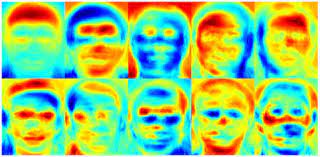

### EigenFaces Face Recognizer Recognizer

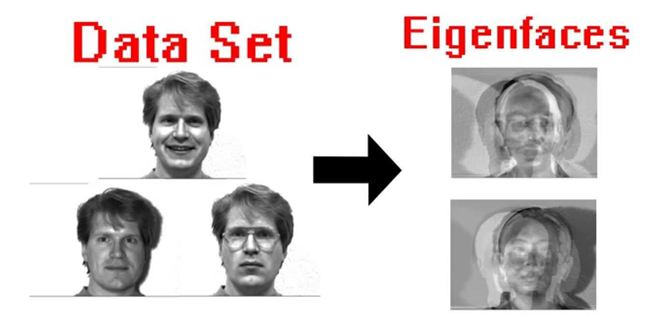

We have already seen it in previous notebook

### FisherFaces Face Recognizer 

Consider following illumination changes. Eigenvector calculations will be overwhelmed by this data

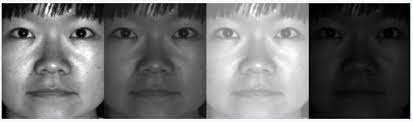


Fisherfaces algorithm, instead of extracting useful features that represent all the faces of all the persons, it extracts useful features that **discriminate** one person from the others. This way features of one person do not dominate (considered more useful features) over the others and you have the features that discriminate one person from the others. 

Below is an image of features extracted using Fisherfaces algorithm.

### Fisher Faces

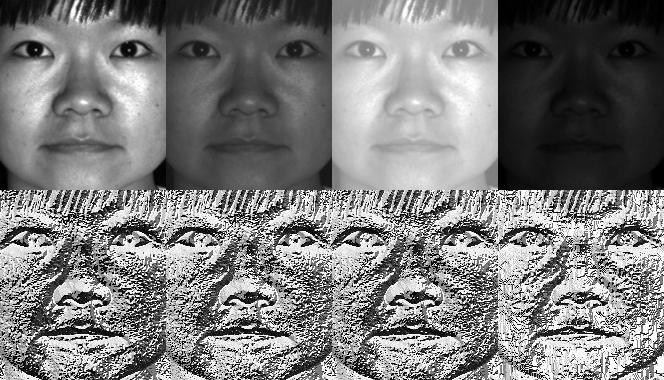

One thing to note here is that Fisherfaces face recognizer only prevents features of one person from dominating over features of the other persons but it still considers illumination changes as useful features. We know that illumination change is not a useful feature to extract as it is not part of the actual face.

### Local Binary Patterns Histograms (LBPH) Face Recognizer 

Idea is to not look at the image as a whole instead find the local features of an image. LBPH alogrithm try to find the local structure of an image and it does that by comparing each pixel with its neighboring pixels. 

Take a 3x3 window and move it one image, at each move (each local part of an image), compare the pixel at the center with its neighbor pixels. The neighbors with intensity value less than or equal to center pixel are denoted by 1 and others by 0. Then you read these 0/1 values under 3x3 window in a clockwise order and you will have a binary pattern like 11100011 and this pattern is local to a specific area of the image. You do this on whole image and you will have a list of local binary patterns. 

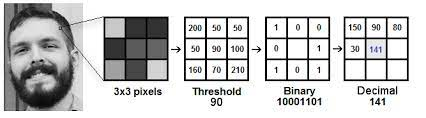

For histogram you convert each binary pattern into a decimal number

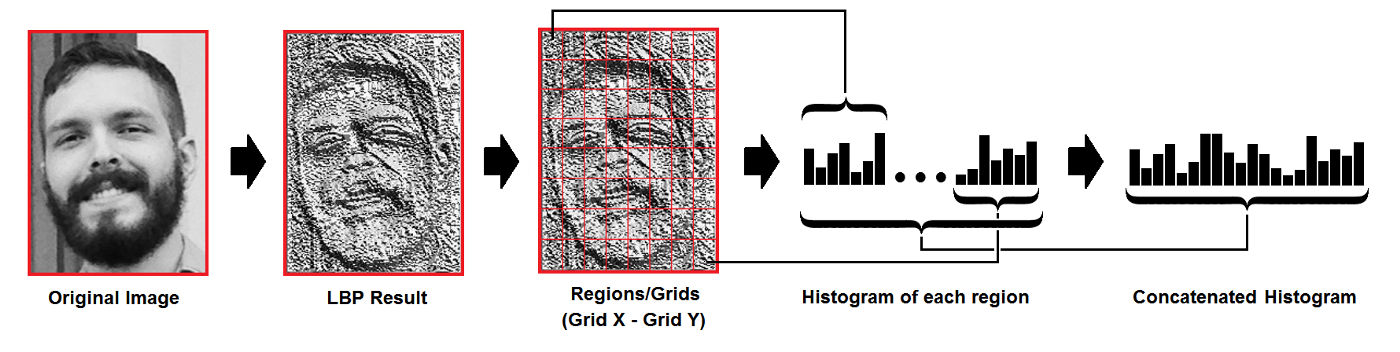


Finally, it concatenates these block histograms to form a one feature vector for one image, which contains all the features we are interested.

Later during recognition, when you will feed a new image to the recognizer for recognition it will generate a histogram for that new image, compare that histogram with the histograms it already has, find the best match histogram and return the person label associated with that best match histogram. 

Below is a list of faces and their respective local binary patterns images. You can see that the LBP images are not affected by changes in light conditions.

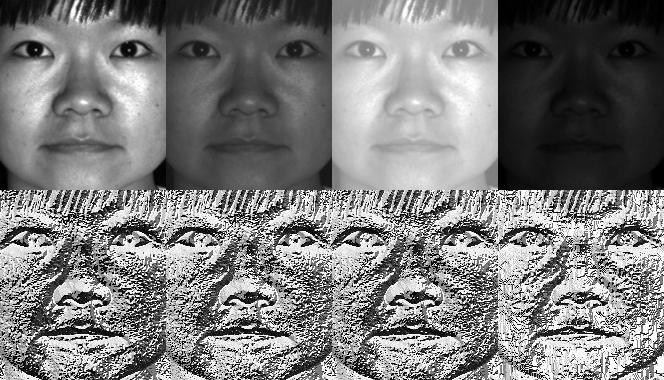!


In [3]:
trainPath = os.path.join(inpDir, dataDir, trainDir)

#there is no label 0 in our training data so class name for label 0 is empty
class_names = ['', 'Virat Kohli', 'M S Dhoni']


###  LBPRecognizer

In [4]:
#function to detect face and retun only faces
def fn_detect_face(img):
    
    '''
    Args:
        img: Image numpy matrix
    Return: only face part of the image and bounding box
    '''
    
    #convert to gray scale as opencv face detector expects gray images
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    #load face detector, 
    face_cascade = cv2.CascadeClassifier(os.path.join(casDir, casFile))

    # detect multiscale as some images may be closer to camera than others
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.2, minNeighbors=5);
    
    faceImg = img.copy()
    
    for (x, y, w, h) in faces:
        cv2.rectangle(faceImg, (x,y), (x+w, y+h), MARK_COLOR, 2)
    
    
    #if no faces are detected then return None, None
    if (len(faces) == 0):
        return None, None
    
    #under the assumption that there will be only one face,
    #extract the face area
    (x, y, w, h) = faces[0]
    
    
    #return only the face part of the image
    return gray[y:y+w, x:x+h], faces[0]

In [5]:
# Read images from the folder and return two lists (faces and labels)
def fn_prepare_training_data(dataFolderPath):
    
    '''
    Args:
        dataFolderPath: path of folder where all images are stored
    return:
        faces: list of images
        labels: list of labels
    
    '''
        
    #list to hold all subject faces
    faces = []
    #list to hold labels for all subjects
    labels = []
    
    #get the directories from the data folder
    dirs = os.listdir(dataFolderPath)
    

    
    # iterate through the directories
    for dirName in dirs:
        
        #our subject directories start with letter 's'
        if not dirName.startswith("s"):
            continue;
            
        #extract label number  from dir name
        label = int(dirName.replace("s", ""))
        
        #build path of directory containing images for current class
        classDirPath = os.path.join(dataFolderPath , dirName)
        
        #get the image names inside the class directory
        classImgNames = os.listdir(classDirPath)
        
        #detect face and add face to list of faces
        for imgName in classImgNames:
            
            #ignore system files like .DS_Store
            if imgName.startswith("."):
                continue;
            
            #build image path
            imagePath = os.path.join(classDirPath, imgName)

            #read image
            img = cv2.imread(imagePath)
            
            #display an image window to show the image 
            #cv2.imshow("Training on image...", img)
            
            
            
            #detect face
            face, rect = fn_detect_face(img)
            
            #ignore if no face detected
            if face is not None:
                #add face to list of faces
                faces.append(face)
                #add label for this face
                labels.append(label)
            else:
                #display an image window to show the image 
                cv2.imshow("No Face found...", img)
                while True:
                    if cv2.waitKey(1) & 0xFF == ord('q'):
                        break
                        
    cv2.destroyAllWindows()
    cv2.waitKey(1)
    cv2.destroyAllWindows()
    
    return faces, labels

In [6]:
# Traning Data -> two list one with faces, other with labels
print("Preparing data", end = '...')

faces, labels = fn_prepare_training_data(trainPath)
print("data prepared")

print("Total faces: ", len(faces))
print("Total labels: ", len(labels))

Preparing data...

data prepared
Total faces:  18
Total labels:  18


In [7]:
# uncoment the recognizer to be used

# LBPH face recognizer 
face_recognizer = cv2.face.LBPHFaceRecognizer_create(radius = 2)

# EigenFaceRecognizer by replacing above line with 
#face_recognizer = cv2.face.EigenFaceRecognizer_create()

# FisherFaceRecognizer by replacing above line with 
#face_recognizer = cv2.face.FisherFaceRecognizer_create()

In [8]:
face_recognizer.train(faces, np.array(labels))

In [9]:
#draw rectangle on image 
def fn_draw_rectangle(im, rect):
    '''
    Args:
        im: np.ndarray Image
        rect: typle (x, y, w, h) rectangle with top left (x, y) and size (w,h)
    return: original image modified
    '''
    
    (x, y, w, h) = rect
    
    cv2.rectangle(im, (x, y), (x+w, y+h), MARK_COLOR, 2)
    
# Put text on the image

def fn_draw_text(im, text, x, y):
    '''
    Args:
        im: np.ndarray Image
        text: text to be marked
        rect: typle (x, y, w, h) rectangle with top left (x, y) and size (w,h)
    return: original image modified
    '''
    cv2.putText(im, text, (x, y), cv2.FONT_HERSHEY_PLAIN, 1.5, MARK_COLOR, 2)

In [10]:
#Make predictions and draw rectangle

def predict(test_img):
    '''
    Args:
        img: np.ndarray Image
    '''
    
    #make a copy of the image as we don't want to change original image
    tImg = test_img.copy()
    
    #detect faces
    face, rect = fn_detect_face(tImg)

    #predict label
    label, _ = face_recognizer.predict(face)
    
    print ('label', label, 'rect', rect)
    
    #get name of respective label 
    label_text = class_names[label]
    
    print ('label_text', label_text)
    
    #draw a rectangle around face detected
    
    fn_draw_rectangle(tImg, rect)
    
    #draw name of predicted person
    fn_draw_text(tImg, label_text, rect[0], rect[1]-5)
    
    return tImg

In [11]:
testPath = os.path.join(inpDir, dataDir, testDir)

imgList = [f for f in os.listdir(testPath) if os.path.isfile(os.path.join(testPath, f))]

In [12]:
imgList

['virat_test_01.xcf',
 'virat_test_02.jpg',
 'msdhoni-11.jpg',
 'virat_test_02.xcf',
 'virat_test_01.jpg']

In [13]:
print("Predicting images...")

testImgName = imgList[1]
#load test images
test_img1 = cv2.imread(os.path.join(testPath, testImgName))

#perform a prediction
predicted_img1 = predict(test_img1)

print("Prediction complete")

#display images
cv2.imshow(testImgName, predicted_img1)


while (True):

    if cv2.waitKey(1) & 0xFF == ord('q'):
            break

cv2.destroyAllWindows()

Predicting images...
label 1 rect [161 268 235 235]
label_text Virat Kohli
Prediction complete


In [15]:
print("Predicting images...")

testImgName = imgList[2]
#load test images
test_img1 = cv2.imread(os.path.join(testPath, testImgName))

#perform a prediction
predicted_img1 = predict(test_img1)

print("Prediction complete")

#display both images
cv2.imshow(testImgName, predicted_img1)


while (True):

    if cv2.waitKey(1) & 0xFF == ord('q'):
            break

cv2.destroyAllWindows()

Predicting images...
label 2 rect [146 149 206 206]
label_text M S Dhoni
Prediction complete
